In [1]:
import math
import copy  # 创建复合对象(包括列表、元组、字典和用户定义对象的实例)的深浅复制
import numpy as np


# 生成随机数据，5个高斯模型
def generate_data(sigma, N, mu1, mu2, mu3, mu4, mu5, alpha):
    global X  # 可观测数据集
    X = np.zeros((N, 2))  # 初始化X，N行2列。2维数据，N个样本
    X = np.mat(X)

    global mu  # 随机初始化mu1，mu2，mu3，mu4
    mu = np.random.random((5, 2))
    mu = np.mat(mu)

    global sigma_  # 随机初始化协方差矩阵
    sigma_ = np.repeat(np.expand_dims(np.eye(2), axis=0), 5, axis=0)

    global alpha_  # 初始化混合项系数
    alpha_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

    global excep  # 期望第i个样本属于第j个模型的概率的期望
    excep = np.zeros((N, 5))
    """
    # 填充矩阵X
    for i in range(N):
        if np.random.random(1) < 0.2:  # np.random.random()生成0-1之间随机数
            X[i, :] = np.random.multivariate_normal(mu1, sigma, 1)  # 用第一个高斯模型生成2维数据
            # np.random.multivariate_normal（mean,cov,size）返回服从多元正态分布的样本值
        elif 0.2 <= np.random.random(1) < 0.4:
            X[i, :] = np.random.multivariate_normal(mu2, sigma, 1)  # 用第二个高斯模型生成2维数据
        elif 0.4 <= np.random.random(1) < 0.6:
            X[i, :] = np.random.multivariate_normal(mu3, sigma, 1)  # 用第三个高斯模型生成2维数据
        elif 0.6 <= np.random.random(1) < 0.8:
            X[i, :] = np.random.multivariate_normal(mu4, sigma, 1)  # 用第四个高斯模型生成2维数据
        else:
            X[i, :] = np.random.multivariate_normal(mu5, sigma, 1)  # 用第五个高斯模型生成2维数据

    
    """
    for i in range(N):
        if np.random.random(1) < 0.5:  # np.random.random()生成0-1之间随机数
            X[i, :] = np.random.multivariate_normal(mu1, sigma, 1)  # 用第一个高斯模型生成2维数据
            # np.random.multivariate_normal（mean,cov,size）返回服从多元正态分布的样本值
        else:
            X[i, :] = np.random.multivariate_normal(mu4, sigma, 1)  # 用第二个高斯模型生成2维数据


    #print("可观测数据：\n", X)  # 输出可观测样本
    print("初始化的均值：", mu)  # 输出初始化的mu
    print("初始化的协方差：", sigma_)  # 输出初始化的sigma_


# E步：计算后验概率（隐藏变量）
def e_step(k, N):
    global X
    global mu
    global sigma_
    global alpha_
    global excep

    for i in range(N):
        denom = 0
        for j in range(0, k):
            denom += alpha_[j] * np.exp(
                -(X[i, :] - mu[j, :]) * np.mat(sigma_[j] + np.eye(2) * 0.0001).I * np.transpose(X[i, :] - mu[j, :]) / 2) / (
                                 np.sqrt(np.linalg.det(sigma_[j] + np.eye(2) * 0.0001)))
        for j in range(0, k):
            numer = np.exp(-(X[i, :] - mu[j, :]) * np.mat(sigma_[j] + np.eye(2) * 0.0001).I * np.transpose(X[i, :] - mu[j, :]) / 2) / (
                        np.sqrt(np.linalg.det(sigma_[j] + np.eye(2) * 0.0001)))
            excep[i, j] = alpha_[j] * numer / denom

    #print("隐藏变量：\n", excep)


# M步：更新均值、协方差矩阵、混合项系数
def m_step(k, N):
    global X
    global mu
    global sigma_
    global alpha_
    global excep

    for j in range(0, k):
        denom = 0  # 分母
        numer1 = 0  # 均值的分子
        numer2 = 0  # 协方差的分子
        for i in range(N):
            numer1 += excep[i, j] * X[i, :]
            denom += excep[i, j]
        mu[j, :] = numer1 / denom  # 求均值
        alpha_[j] = denom / N  # 求混合项系数
        for i in range(N):
            numer2 += excep[i, j] * np.transpose(X[i, :] - mu[j, :]) * (X[i, :] - mu[j, :])
        sigma_[j] = numer2 / denom  # 求协方差


if __name__ == '__main__':  # 实现在程序/模块之间互相调用时声明一个运行界限的功能
    iter_num = 1000  # 迭代次数
    N = 300  # 样本数目
    k = 5  # 高斯模型数
    # probility = np.zeros(N)    #混合高斯分布
    u1 = [5, 10]
    u2 = [10, 15]
    u3 = [15, 20]
    u4 = [20, 15]
    u5 = [25, 30]
    sigma = np.mat([[10, 0], [0, 10]])  # 协方差矩阵
    alpha = [0.3, 0.1, 0.2, 0.3, 0.1]  # 混合项系数

    generate_data(sigma, N, u1, u2, u3, u4, u5, alpha)  # 生成数据

    # 迭代计算
    for i in range(iter_num):
        err = 0  # 均值误差
        err_alpha = 0  # 混合项系数误差
        Old_mu = copy.deepcopy(mu)  # copy.deepcopy表示深复制
        Old_alpha = copy.deepcopy(alpha_)

        e_step(k, N)  # E步
        m_step(k, N)  # M步

        print("迭代次数:", i + 1)
        print("估计的均值:", mu)
        print("估计的协方差矩阵:", sigma_)
        print("估计的混合项系数:", alpha_)
        for z in range(k):
            err += (abs(Old_mu[z, 0] - mu[z, 0]) + abs(Old_mu[z, 1] - mu[z, 1]))  # 计算均值误差（即当前值与上一次迭代值的误差）
            err_alpha += abs(Old_alpha[z] - alpha_[z])  # 计算混合项系数误差
        if (err <= 0.001) and (err_alpha < 0.001):  # 达到精度退出迭代
            print(err, err_alpha)
            break

初始化的均值： [[0.57341788 0.71241316]
 [0.5791194  0.88715765]
 [0.83603633 0.590837  ]
 [0.49419885 0.97971961]
 [0.48481821 0.44933929]]
初始化的协方差： [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
迭代次数: 1
估计的均值: [[ 7.56062925  9.56624051]
 [10.95595928 12.50598505]
 [18.30104099 12.42909862]
 [ 8.20707083 12.46025618]
 [ 3.7869564   5.9839425 ]]
估计的协方差矩阵: [[[39.85658155 14.35941425]
  [14.35941425 14.83207527]]

 [[56.41120649 20.39728911]
  [20.39728911 17.08698539]]

 [[36.28819375 13.24781886]
  [13.24781886 14.60664158]]

 [[47.26251866 16.04756316]
  [16.04756316 15.64685498]]

 [[10.21362419  2.94946664]
  [ 2.94946664  8.29250451]]]
估计的混合项系数: [0.04350445 0.27147816 0.31331516 0.36710973 0.0045925 ]
迭代次数: 2
估计的均值: [[ 6.89283273  9.20751356]
 [10.90883677 12.45087566]
 [18.86602383 12.79021756]
 [ 7.82955439 12.29425936]
 [ 3.8754942   5.96091809]]
估计的协方差矩阵: [[[31.15787249 11.40482874]
  [11.40482874 13.67175421]]

 [[58.1859

迭代次数: 17
估计的均值: [[ 5.12374382  9.17495746]
 [14.80877078 13.97101246]
 [19.97241478 14.55678332]
 [ 5.00471309 10.76006352]
 [ 2.16708409  6.55742043]]
估计的协方差矩阵: [[[ 9.26920745 -1.52090603]
  [-1.52090603  7.57045999]]

 [[49.47885404  5.0806781 ]
  [ 5.0806781  15.35354607]]

 [[ 7.655558    0.87657065]
  [ 0.87657065 11.10285607]]

 [[ 8.82970049 -0.63364984]
  [-0.63364984  9.3757958 ]]

 [[ 0.9923218   1.91779762]
  [ 1.91779762  5.97376483]]]
估计的混合项系数: [0.0973935  0.11690258 0.40386645 0.33254537 0.0492921 ]
迭代次数: 18
估计的均值: [[ 5.12639416  9.18798731]
 [14.99308926 14.07781857]
 [19.96532831 14.55532712]
 [ 5.02643022 10.74566554]
 [ 2.18731074  6.68304925]]
估计的协方差矩阵: [[[ 9.48434047 -1.59053771]
  [-1.59053771  7.73585296]]

 [[49.09559946  4.22250631]
  [ 4.22250631 15.05918102]]

 [[ 7.64464309  0.91847654]
  [ 0.91847654 11.11288839]]

 [[ 8.85010137 -0.65136656]
  [-0.65136656  9.35642236]]

 [[ 0.98573873  2.00785167]
  [ 2.00785167  6.21352919]]]
估计的混合项系数: [0.09752176 0.11481

迭代次数: 33
估计的均值: [[ 4.97759717  9.26174861]
 [17.06663933 15.41136106]
 [19.91010112 14.42896538]
 [ 5.25767161 10.688422  ]
 [ 2.47296769  7.61956037]]
估计的协方差矩阵: [[[10.18604574 -1.32570306]
  [-1.32570306  9.76023528]]

 [[40.76373829 -3.22843255]
  [-3.22843255 11.41826811]]

 [[ 7.52528018  1.43040653]
  [ 1.43040653 11.42315885]]

 [[ 9.55634644 -0.87172413]
  [-0.87172413  8.98230095]]

 [[ 1.17011585  2.65792922]
  [ 2.65792922  7.92003335]]]
估计的混合项系数: [0.09905784 0.09789693 0.40005205 0.33827578 0.06471739]
迭代次数: 34
估计的均值: [[ 4.97373493  9.25274364]
 [17.16489979 15.49602382]
 [19.90746917 14.41566885]
 [ 5.26669509 10.69323438]
 [ 2.47776821  7.6327966 ]]
估计的协方差矩阵: [[[10.095312   -1.27909674]
  [-1.27909674  9.9334227 ]]

 [[40.2708073  -3.51692791]
  [-3.51692791 11.14458304]]

 [[ 7.52183227  1.45986202]
  [ 1.45986202 11.44708485]]

 [[ 9.61606915 -0.88556241]
  [-0.88556241  8.9192974 ]]

 [[ 1.17287655  2.66403771]
  [ 2.66403771  7.9298235 ]]]
估计的混合项系数: [0.09919318 0.09739

迭代次数: 49
估计的均值: [[ 5.23492165  9.08650583]
 [17.75706537 17.00697847]
 [19.91187397 14.15142063]
 [ 5.2792535  10.76621357]
 [ 2.49256987  7.69294115]]
估计的协方差矩阵: [[[ 7.26340932 -0.07292914]
  [-0.07292914 13.0377465 ]]

 [[35.88603624 -4.57860151]
  [-4.57860151  5.29033381]]

 [[ 7.81870114  1.58525868]
  [ 1.58525868 11.55079646]]

 [[10.87894476 -1.04752329]
  [-1.04752329  7.66483178]]

 [[ 1.18055151  2.66004273]
  [ 2.66004273  7.7834244 ]]]
估计的混合项系数: [0.10179104 0.08965814 0.40032599 0.34227142 0.0659534 ]
迭代次数: 50
估计的均值: [[ 5.27317337  9.09267401]
 [17.73585738 17.11478036]
 [19.91608164 14.13496482]
 [ 5.27172991 10.76713685]
 [ 2.49120573  7.69109398]]
估计的协方差矩阵: [[[ 7.03612774  0.0375592 ]
  [ 0.0375592  13.1926076 ]]

 [[35.69388467 -4.40964615]
  [-4.40964615  4.87282105]]

 [[ 7.87611289  1.57238641]
  [ 1.57238641 11.51723384]]

 [[10.96215809 -1.05700384]
  [-1.05700384  7.60610197]]

 [[ 1.17984988  2.65728806]
  [ 2.65728806  7.77063867]]]
估计的混合项系数: [0.10204934 0.08877

迭代次数: 65
估计的均值: [[ 5.85097756  9.1906868 ]
 [17.47001562 17.71637081]
 [19.9128855  14.11891338]
 [ 5.1436447  10.77465561]
 [ 2.4985702   7.72949027]]
估计的协方差矩阵: [[[ 4.51971546  1.99345812]
  [ 1.99345812 13.55090926]]

 [[37.2136991  -4.32139062]
  [-4.32139062  2.97200245]]

 [[ 8.33332409  1.50432562]
  [ 1.50432562 11.28578058]]

 [[11.69058272 -1.36638472]
  [-1.36638472  7.43450504]]

 [[ 1.17385089  2.63953792]
  [ 2.63953792  7.74929567]]]
估计的混合项系数: [0.10308104 0.07601769 0.41293533 0.33809438 0.06987156]
迭代次数: 66
估计的均值: [[ 5.88094193  9.19260074]
 [17.45102374 17.72015005]
 [19.91116425 14.12431691]
 [ 5.1384484  10.77333772]
 [ 2.50230437  7.74048677]]
估计的协方差矩阵: [[[ 4.39215717  2.12122515]
  [ 2.12122515 13.54181732]]

 [[37.44580666 -4.37420286]
  [-4.37420286  2.95638358]]

 [[ 8.34830033  1.49962243]
  [ 1.49962243 11.29236533]]

 [[11.71214198 -1.39602437]
  [-1.39602437  7.44531463]]

 [[ 1.1751068   2.64281769]
  [ 2.64281769  7.76166573]]]
估计的混合项系数: [0.10257559 0.07533

迭代次数: 81
估计的均值: [[ 6.11437213  9.57745707]
 [17.35722438 17.71077753]
 [19.89113064 14.19019251]
 [ 5.17879661 10.66831113]
 [ 2.56958611  7.85768572]]
估计的协方差矩阵: [[[ 2.44395255  3.2172671 ]
  [ 3.2172671  15.22075708]]

 [[39.46101669 -4.91475596]
  [-4.91475596  2.80354726]]

 [[ 8.49751102  1.40855865]
  [ 1.40855865 11.37412963]]

 [[11.9580887  -1.76665342]
  [-1.76665342  7.6046068 ]]

 [[ 1.19541739  2.68202977]
  [ 2.68202977  8.05259489]]]
估计的混合项系数: [0.08619506 0.06742302 0.42113401 0.3451839  0.08006401]
迭代次数: 82
估计的均值: [[ 6.12479478  9.63128942]
 [17.36909073 17.70702854]
 [19.88999539 14.19366616]
 [ 5.18653395 10.65885603]
 [ 2.57509666  7.86033656]]
估计的协方差矩阵: [[[ 2.2875767   3.25431775]
  [ 3.25431775 15.48206045]]

 [[39.49224153 -4.935077  ]
  [-4.935077    2.79533278]]

 [[ 8.50401196  1.40108852]
  [ 1.40108852 11.37787309]]

 [[11.9745137  -1.78406768]
  [-1.78406768  7.60758052]]

 [[ 1.19597554  2.68019366]
  [ 2.68019366  8.07118035]]]
估计的混合项系数: [0.08470322 0.06696

迭代次数: 97
估计的均值: [[ 6.0532814   9.51550144]
 [17.23380283 17.70797789]
 [19.87950073 14.24005609]
 [ 5.30360327 10.64556994]
 [ 2.63732695  7.86227239]]
估计的协方差矩阵: [[[ 1.11331083  3.93706321]
  [ 3.93706321 19.33617734]]

 [[41.92035235 -5.5667429 ]
  [-5.5667429   2.66192262]]

 [[ 8.56831026  1.3139564 ]
  [ 1.3139564  11.438901  ]]

 [[11.78666605 -1.75269693]
  [-1.75269693  7.35344457]]

 [[ 1.2408884   2.67832525]
  [ 2.67832525  8.11417701]]]
估计的混合项系数: [0.05944812 0.0622808  0.42591249 0.36544187 0.08691672]
迭代次数: 98
估计的均值: [[ 6.04548479  9.44508059]
 [17.19415017 17.71133693]
 [19.87950606 14.24223482]
 [ 5.30593145 10.64889459]
 [ 2.63601053  7.85602616]]
估计的协方差矩阵: [[[ 1.10989518  3.9750483 ]
  [ 3.9750483  19.32089172]]

 [[42.20580851 -5.6033678 ]
  [-5.6033678   2.65040718]]

 [[ 8.57079049  1.31275577]
  [ 1.31275577 11.44284912]]

 [[11.749553   -1.7377324 ]
  [-1.7377324   7.3501639 ]]

 [[ 1.24239809  2.67869881]
  [ 2.67869881  8.10901132]]]
估计的混合项系数: [0.05805662 0.06216

迭代次数: 113
估计的均值: [[ 6.32937756  9.55856304]
 [17.09399688 17.50656517]
 [19.86525031 14.28438857]
 [ 5.28308322 10.60593262]
 [ 2.58680072  7.72172104]]
估计的协方差矩阵: [[[ 1.69334422  6.65786564]
  [ 6.65786564 26.8115391 ]]

 [[45.160388   -5.27259487]
  [-5.27259487  2.1281478 ]]

 [[ 8.6115391   1.25756199]
  [ 1.25756199 11.59640705]]

 [[11.08265714 -1.57527602]
  [-1.57527602  7.42377091]]

 [[ 1.23073069  2.64524631]
  [ 2.64524631  7.98656861]]]
估计的混合项系数: [0.04236641 0.05740642 0.43078837 0.38793557 0.08150324]
迭代次数: 114
估计的均值: [[ 6.34535478  9.59420168]
 [17.11864295 17.48457816]
 [19.86084105 14.29056049]
 [ 5.28092392 10.60206078]
 [ 2.58289986  7.71444836]]
估计的协方差矩阵: [[[ 1.72536587  6.79945263]
  [ 6.79945263 27.37106818]]

 [[45.43449427 -5.32344144]
  [-5.32344144  2.07131193]]

 [[ 8.62554852  1.24479662]
  [ 1.24479662 11.61663382]]

 [[11.04716889 -1.55850054]
  [-1.55850054  7.44509246]]

 [[ 1.22886935  2.64447815]
  [ 2.64447815  7.98505909]]]
估计的混合项系数: [0.0416698  0.056

迭代次数: 129
估计的均值: [[ 6.38068872  9.68175147]
 [17.2604834  17.46486493]
 [19.79725953 14.35674071]
 [ 5.27052951 10.59932961]
 [ 2.55144399  7.64685061]]
估计的协方差矩阵: [[[ 1.86664438  7.35262168]
  [ 7.35262168 29.44905963]]

 [[51.61730829 -6.44670916]
  [-6.44670916  1.62327849]]

 [[ 8.89309255  1.06381431]
  [ 1.06381431 11.66984362]]

 [[10.90075156 -1.48911067]
  [-1.48911067  7.49122601]]

 [[ 1.20587708  2.60602643]
  [ 2.60602643  7.89690065]]]
估计的混合项系数: [0.039694   0.04621039 0.44138918 0.39433718 0.07836925]
迭代次数: 130
估计的均值: [[ 6.38124642  9.68376732]
 [17.25801138 17.4704221 ]
 [19.79499553 14.35923334]
 [ 5.27018073 10.59940942]
 [ 2.5509994   7.64583114]]
估计的协方差矩阵: [[[ 1.86803861  7.35791694]
  [ 7.35791694 29.46891046]]

 [[51.96556924 -6.49656216]
  [-6.49656216  1.61377715]]

 [[ 8.90523955  1.05718401]
  [ 1.05718401 11.6666815 ]]

 [[10.8979225  -1.48823027]
  [-1.48823027  7.49234443]]

 [[ 1.20554335  2.60533312]
  [ 2.60533312  7.89518072]]]
估计的混合项系数: [0.03969093 0.045

迭代次数: 145
估计的均值: [[ 6.38433606  9.69489666]
 [17.2055233  17.51659071]
 [19.78069501 14.37858118]
 [ 5.26798707 10.60021459]
 [ 2.54887697  7.64114248]]
估计的协方差矩阵: [[[ 1.87593077  7.38784995]
  [ 7.38784995 29.58092885]]

 [[54.85487372 -6.88795028]
  [-6.88795028  1.56817254]]

 [[ 8.98854225  1.01174817]
  [ 1.01174817 11.63921648]]

 [[10.87870397 -1.48200231]
  [-1.48200231  7.50325267]]

 [[ 1.20413573  2.60261814]
  [ 2.60261814  7.88802052]]]
估计的混合项系数: [0.03966515 0.04206026 0.4455172  0.39459994 0.07815745]
迭代次数: 146
估计的均值: [[ 6.38438762  9.69508027]
 [17.20341238 17.51775928]
 [19.78041372 14.37906728]
 [ 5.26794576 10.60023788]
 [ 2.54885098  7.64109407]]
估计的协方差矩阵: [[[ 1.8760713   7.38838211]
  [ 7.38838211 29.58291507]]

 [[54.93116051 -6.89791579]
  [-6.89791579  1.56766846]]

 [[ 8.99035418  1.01074978]
  [ 1.01074978 11.63850543]]

 [[10.87829986 -1.48185369]
  [-1.48185369  7.50357313]]

 [[ 1.20412399  2.602607  ]
  [ 2.602607    7.88797738]]]
估计的混合项系数: [0.03966436 0.041

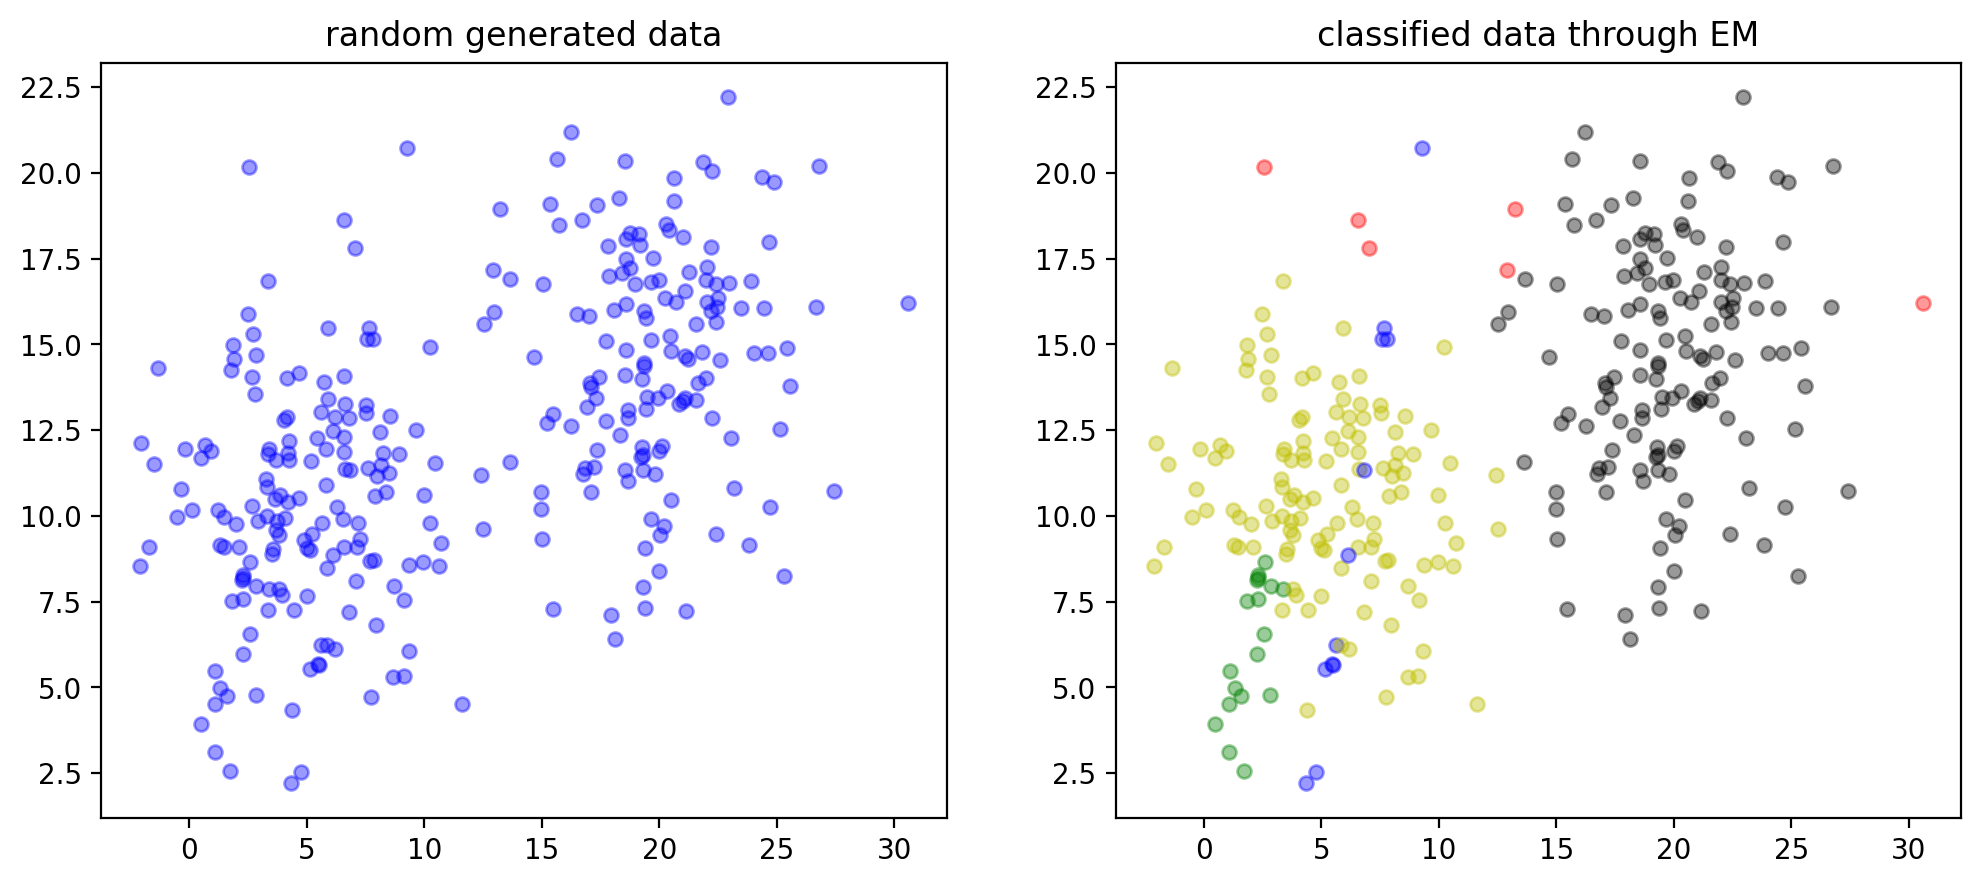

In [9]:
import matplotlib.pyplot as plt
probility = np.zeros(N)    #混合高斯分布
#可视化结果
# 画生成的原始数据
plt.figure(figsize=(12,5),dpi=200)
plt.subplot(121)
plt.scatter(X[:,0].tolist(), X[:,1].tolist(),c='b',s=25,alpha=0.4,marker='o')    #T散点颜色，s散点大小，alpha透明度，marker散点形状
plt.title('random generated data')
#画分类好的数据
plt.subplot(122)
plt.title('classified data through EM')
order=np.zeros(N)
color=['b','r','k','y','g']
for i in range(N):
    for j in range(k):
        if excep[i,j]==max(excep[i,:]):
            order[i]=j     #选出X[i,:]属于第几个高斯模型
        probility[i] += alpha_[int(order[i])]*math.exp(-(X[i,:]-mu[j,:])*np.mat(sigma_[j] + np.eye(2) * 0.0001).I*np.transpose(X[i,:]-mu[j,:]))/(np.sqrt(np.linalg.det(sigma))*2*np.pi)    #计算混合高斯分布
    plt.scatter(X[i, 0], X[i, 1], c=color[int(order[i])], s=25, alpha=0.4, marker='o')      #绘制分类后的散点图
    #绘制三维图像
plt.show()